# Machine Learning Contest
By: Kris Darnell & David Tang

Test run with a larger sized neural network. Contest is described [here](https://github.com/seg/2016-ml-contest).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# Loading Data
filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.fillna(training_data.mean(),inplace=True) # Remove NaN with mean value
training_data

# Converts to category
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [2]:
# Plotting stuff
# Hex color codes
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}   # Dictionary # enumerate puts out ind=0, label=SS, and loops through the whole thing
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
   
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Well Name','Facies','FaciesLabels','Formation'], axis=1)
feature_vectors.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644
min,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000
75%,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000
max,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


***
Normalizing and splitting data

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)


# Training Data

In [4]:
from sklearn.neural_network import MLPClassifier

sizes = (100,100)
clfNN = MLPClassifier(solver='lbfgs', alpha=.015,
                    hidden_layer_sizes=sizes, random_state=1)

clfNN.fit(X_train,y_train)
predicted_NN     = clfNN.predict(X_test)

from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf_NN = confusion_matrix(y_test,predicted_NN)
display_cm(conf_NN,facies_labels,hide_zeros=True)


def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc


adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

print('Facies classification accuracy (NN) = %f' % accuracy(conf_NN))
print('Adjacent facies classification accuracy (NN) = %f' % accuracy_adjacent(conf_NN, adjacent_facies))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    41    11     2                                        54
     CSiS     2   174    26     1                       2         205
     FSiS     1    31   120                                       152
     SiSh                      41     1     6           4          52
       MS                 1     3    38     6           6          54
       WS                 1     6    12    76     4    12     1   112
        D           1                 2          22     2     2    29
       PS           1     2     2     1    17         105     3   131
       BS                                                    41    41
Facies classification accuracy (NN) = 0.792771
Adjacent facies classification accuracy (NN) = 0.949398


## Load Validation Set

In [5]:
filename = 'validation_data_nofacies.csv'
validationFull = pd.read_csv(filename)

validation = validationFull.drop(['Well Name','Formation'], axis=1)

# Normalize data
scaled_validation = scaler.transform(validation)
validation_output = clfNN.predict(scaled_validation)

In [6]:
def make_facies_log_plot(logs, facies_colors):
   #make sure logs are sorted by depth
   logs = logs.sort_values(by='Depth')
   cmap_facies = colors.ListedColormap(
           facies_colors[0:len(facies_colors)], 'indexed')
   
   ztop=logs.Depth.min(); zbot=logs.Depth.max()
   
   cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1) # Makes it a nx1, repeating values along an dimension
   
   f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
   ax[0].plot(logs.GR, logs.Depth, '-g')
   ax[1].plot(logs.ILD_log10, logs.Depth, '-')
   ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
   ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
   ax[4].plot(logs.PE, logs.Depth, '-', color='black')
   im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=9)
   
   divider = make_axes_locatable(ax[5])
   cax = divider.append_axes("right", size="20%", pad=0.05)
   cbar=plt.colorbar(im, cax=cax)
   cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                               'SiSh', ' MS ', ' WS ', ' D  ', 
                               ' PS ', ' BS ']))
   cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
   
   for i in range(len(ax)-1):
       ax[i].set_ylim(ztop,zbot)
       ax[i].invert_yaxis()
       ax[i].grid()
       ax[i].locator_params(axis='x', nbins=3)
   
   ax[0].set_xlabel("GR")
   ax[0].set_xlim(logs.GR.min(),logs.GR.max())
   ax[1].set_xlabel("ILD_log10")
   ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
   ax[2].set_xlabel("DeltaPHI")
   ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
   ax[3].set_xlabel("PHIND")
   ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
   ax[4].set_xlabel("PE")
   ax[4].set_xlim(logs.PE.min(),logs.PE.max())
   ax[5].set_xlabel('Facies')
   
   ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
   ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
   ax[5].set_xticklabels([])
   f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


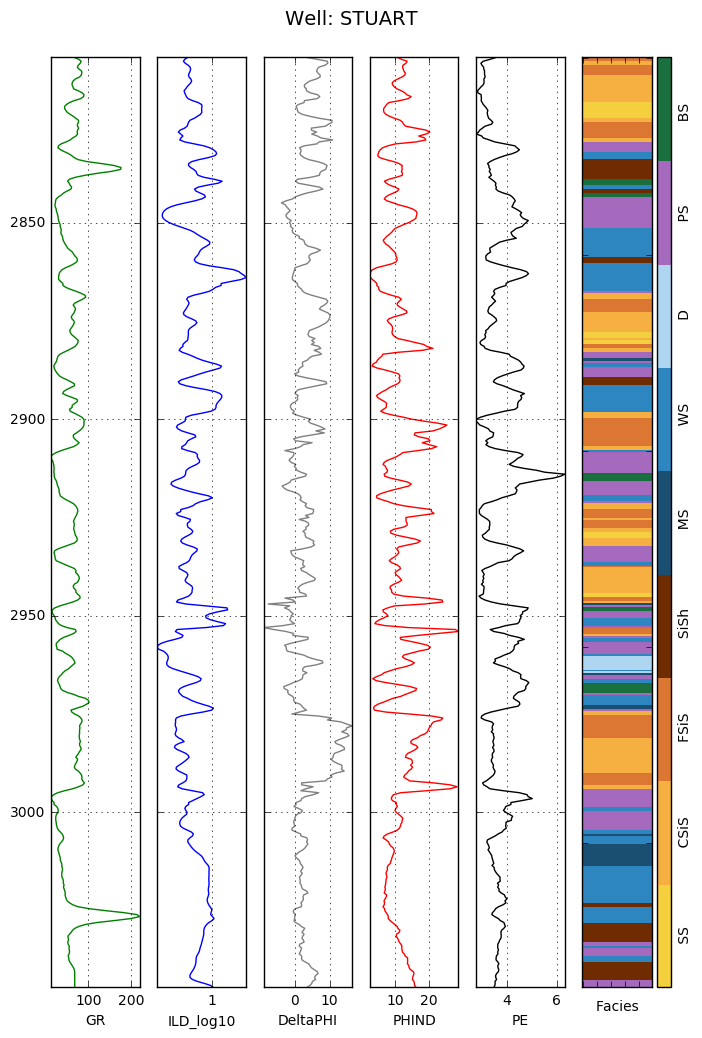

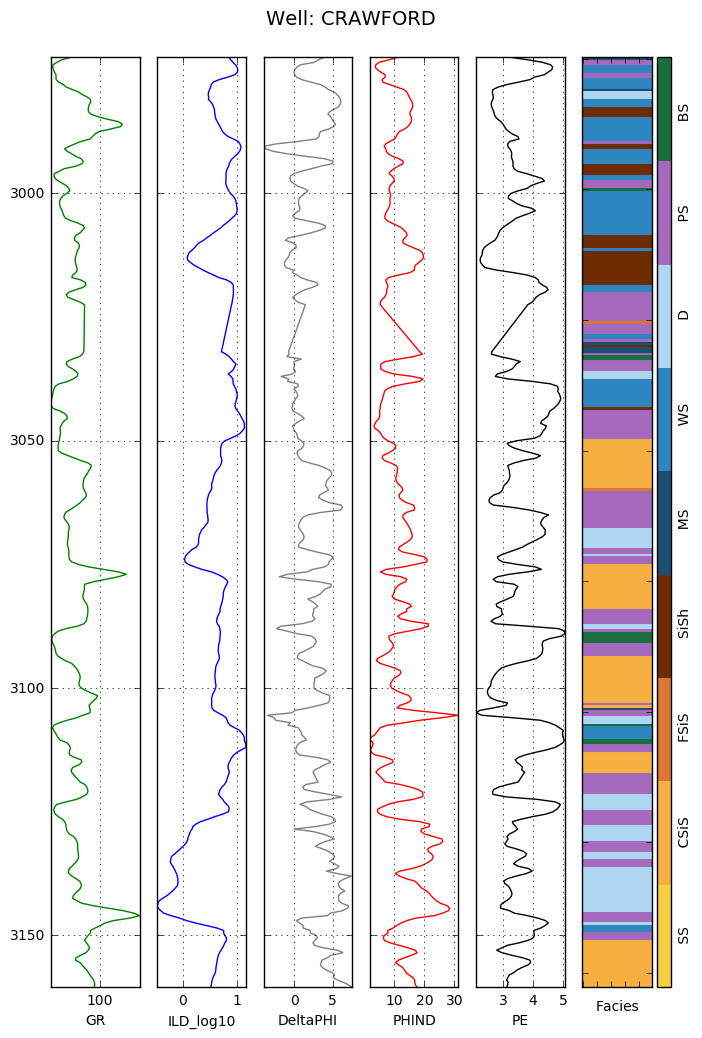

In [11]:
%matplotlib inline
validationFull['Facies']=validation_output
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='STUART'],
    facies_colors=facies_colors)
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='CRAWFORD'],
    facies_colors=facies_colors)


In [12]:
validationFull.to_csv('TangDarnell.csv')